In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# X  --> Y 
X_dim = 1
Z_dim = 256

# Discriminator Net
X = tf.placeholder(tf.float32, shape=[None, X_dim+2], name='X')

D_W1 = tf.Variable(xavier_init([X_dim+2, 256]), name='D_W1')
D_b1 = tf.Variable(tf.zeros(shape=[256]), name='D_b1')

D_W2 = tf.Variable(xavier_init([256, 1]), name='D_W2')
D_b2 = tf.Variable(tf.zeros(shape=[1]), name='D_b2')

theta_D = [D_W1, D_W2, D_b1, D_b2]

# Generator Net
Z = tf.placeholder(tf.float32, shape=[None, Z_dim], name='Z')

G_W0 = tf.Variable(xavier_init([Z_dim, 1024]), name='G_W0')
G_b0 = tf.Variable(tf.zeros(shape=[1024]), name='G_b0')

G_W1 = tf.Variable(xavier_init([1024, X_dim]), name='G_W1')
G_b1 = tf.Variable(tf.zeros(shape=[X_dim]), name='G_b1')

G_W2_true = tf.Variable(xavier_init([X_dim, 512]), name='G_W2_true')
G_b2_true = tf.Variable(tf.zeros(shape=[512]), name='G_b2_true')

G_W2_censor = tf.Variable(xavier_init([X_dim, 512]), name='G_W2_censor')
G_b2_censor = tf.Variable(tf.zeros(shape=[512]), name='G_b2_censor')

G_W22_true = tf.Variable(xavier_init([512, 64]), name='G_W22_true')
G_b22_true = tf.Variable(tf.zeros(shape=[64]), name='G_b22_true')

G_W22_censor = tf.Variable(xavier_init([512, 64]), name='G_W22_censor')
G_b22_censor = tf.Variable(tf.zeros(shape=[64]), name='G_b22_censor')

G_W3_true = tf.Variable(xavier_init([64, 1]), name='G_W3_true')
G_b3_true = tf.Variable(tf.zeros(shape=[1]), name='G_b3_true')

G_W3_censor = tf.Variable(xavier_init([64, 1]), name='G_W3_censor')
G_b3_censor = tf.Variable(tf.zeros(shape=[1]), name='G_b3_censor')

theta_G = [G_W0, G_W1, G_W2_true, G_W22_true, G_W3_true, G_W2_censor, G_W22_censor, G_W3_censor, \
           G_b0, G_b1, G_b2_true, G_b22_true, G_b3_true, G_b2_censor, G_b22_censor, G_b3_censor]

In [3]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

def generate_real(m, d):
    x = np.random.uniform(-1., 1., size=[m, d])
    t = np.sum(x**2, axis=1, keepdims=True)
    c = 0.2*np.ones_like(t)
    y = np.maximum(t,c) # left censoring
    ind = np.argmax([c,t], axis=0) # indicator of censoring
    return np.concatenate((x,y,ind), axis=1)

def generator(z):
    G_x = tf.matmul(tf.nn.relu(tf.matmul(z, G_W0) + G_b0), G_W1) + G_b1
    
    G_h_true = tf.nn.relu(tf.matmul(G_x, G_W2_true) + G_b2_true)
    G_h_censor = tf.nn.relu(tf.matmul(G_x, G_W2_censor) + G_b2_censor)
    
    G_h2_true = tf.nn.relu(tf.matmul(G_h_true, G_W22_true) + G_b22_true)
    G_h2_censor = tf.nn.relu(tf.matmul(G_h_censor, G_W22_censor) + G_b22_censor)
    
    G_t = tf.matmul(G_h2_true, G_W3_true) + G_b3_true
    G_c = tf.matmul(G_h2_censor, G_W3_censor) + G_b3_censor
    
    G_y = tf.maximum(G_t, G_c) # left censoring
    # TODO: how to tell neural network which data is censored?
    # using sigmoid function trick
    G_y_ind = tf.sigmoid(0.1*(G_t - G_c))
    
    G_prob = tf.concat([G_x, G_y, G_y_ind], axis=1)

    return G_prob

def generator2(z):
    G_x = tf.matmul(tf.nn.relu(tf.matmul(z, G_W0) + G_b0), G_W1) + G_b1
    G_h_true = tf.nn.relu(tf.matmul(G_x, G_W2_true) + G_b2_true)
    G_t = tf.matmul(G_h_true, G_W3_true) + G_b3_true
    G_y_ind = tf.ones_like(G_t)
    G_prob = tf.concat([G_x, G_t, G_y_ind], axis=1)
    
    return G_prob

def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [4]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

In [ ]:
D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake) # want it large --> 1
G_loss = -tf.reduce_mean(D_fake) # want it small --> -1

D_solver = (tf.train.RMSPropOptimizer(learning_rate=1e-1)
            .minimize(-D_loss, var_list=theta_D))
G_solver = (tf.train.RMSPropOptimizer(learning_rate=1e-1)
            .minimize(G_loss, var_list=theta_G))

clip_D = [p.assign(tf.clip_by_value(p, -0.1, 0.1)) for p in theta_D]

mb_size = 128

sess = tf.Session()
sess.run(tf.global_variables_initializer())

J = 10
K = 1
for it in range(100001):
    for _ in range(J):
        X_mb = generate_real(mb_size, X_dim)
        _, D_loss_curr, _ = sess.run(
            [D_solver, D_loss, clip_D],
            feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)}
        )
        
    for k in range(K):
        _, G_loss_curr = sess.run(
            [G_solver, G_loss],
            feed_dict={Z: sample_Z(mb_size, Z_dim)}
        )

#     if D_loss_curr < 1.0:
#         K = 20
#         J = 1
#     elif G_loss_curr > 2.0:
#         K = 20
#         J = 1
#     else:
#         K = 1
#         J = 1
        
#     if G_loss_curr < 0.8:
#         J = 10
#         K = 1
        
    if it % 100 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

Iter: 0
D loss: 0.03303
G_loss: -0.4867

Iter: 100
D loss: 0.04577
G_loss: -0.4513

Iter: 200
D loss: 0.02916
G_loss: -0.4794

Iter: 300
D loss: 0.02181
G_loss: -0.4835



In [23]:
# test
G_W2_true_final = G_W2_true.eval(sess)
G_b2_true_final = G_b2_true.eval(sess)
G_W22_true_final = G_W22_true.eval(sess)
G_b22_true_final = G_b22_true.eval(sess)

G_W3_true_final = G_W3_true.eval(sess)
G_b3_true_final = G_b3_true.eval(sess)

G_W2_censor_final = G_W2_censor.eval(sess)
G_b2_censor_final = G_b2_censor.eval(sess)
G_W22_censor_final = G_W22_censor.eval(sess)
G_b22_censor_final = G_b22_censor.eval(sess)

G_W3_censor_final = G_W3_censor.eval(sess)
G_b3_censor_final = G_b3_censor.eval(sess)

In [24]:
import operator
T = generate_real(2000, X_dim)
x = T[:,:-2]
y = T[:,-2:-1]
L = sorted(zip(x,y), key=operator.itemgetter(0))
x, y = zip(*L)

In [25]:
def reLu(x):
    return np.maximum(x,0)

pred = np.dot(reLu(np.dot(reLu(np.dot(x, G_W2_true_final) + G_b2_true_final), G_W22_true_final) \
                   + G_b22_true_final), G_W3_true_final) + G_b3_true_final
pred_c = np.dot(reLu(np.dot(reLu(np.dot(x, G_W2_censor_final) + G_b2_censor_final), G_W22_censor_final) \
                     + G_b22_censor_final), G_W3_censor_final) + G_b3_censor_final

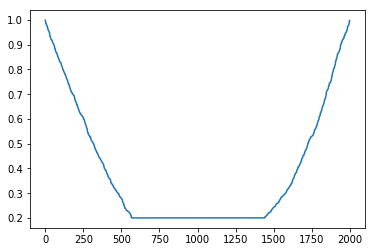

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(y)

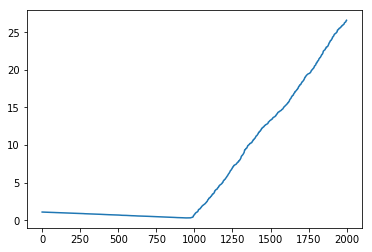

In [27]:
plt.plot(pred)

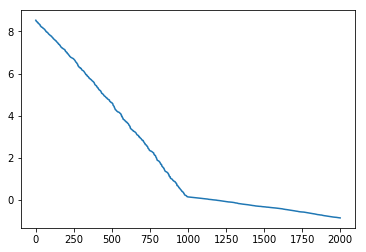

In [28]:
plt.plot(pred_c)

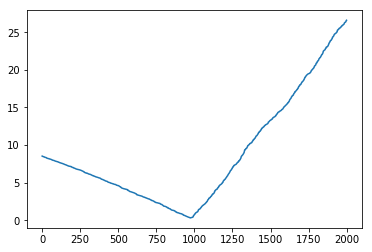

In [29]:
plt.plot(np.maximum(pred, pred_c))